In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from IPython.display import Video
from scipy.io import wavfile
from Kildekode._07_Frekvensanalyse import *

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Frekvensanalyse med DFT del 1

* **Emne AIS2201 - Signalbehandling**
* **Uke 38, 2024**
* **Underviser: Kai Erik Hoff**

# Tema 

* Repetisjon DFT & IDFT
* Spektral Lekkasje
* Vindusfunksjoner 
* Zero Padding

## Repetisjon: DFT av sinusbølge

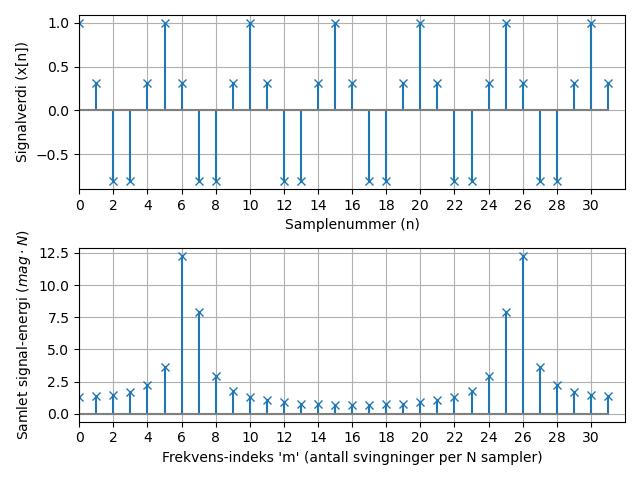

In [2]:
N = 32
n = np.arange(N)
xn = cos(2*pi/5*n)

Xm = np.fft.fft(xn)
    
plt.close(1);plt.figure(1)
plt.subplot(2,1,1)
plt.stem(n, xn, linefmt='-', markerfmt='x', basefmt='grey')
plt.xticks(np.arange(0,N,2))
plt.grid(True)
plt.xlabel("Samplenummer (n)")
plt.ylabel("Signalverdi (x[n])")
plt.xlim([0, N])
plt.subplot(2,1,2)
plt.stem(np.abs(Xm), linefmt='-', markerfmt='x', basefmt='grey')
plt.grid(True)
plt.xlim([0, N])
plt.xticks(np.arange(0,N,2))
plt.xlabel("Frekvens-indeks 'm' (antall svingninger per N sampler)")
plt.ylabel(r"Samlet signal-energi ($mag \cdot N$)");
plt.tight_layout()

# Valg av vinduslengde $N$

* Ved bruk av DFT/FFT bestemmes en *vinduslengde* $N$, som er lengden på signalsegmentet vi analyserer i antall sampler.
* Invers proporsjonalt forhold mellom oppløsning i tid, og oppløsning i frekvensaksen:
    - Høyere vinduslengde $N$ gir flere sampler langs frekvensaksen, og dermed høyere oppløsning og lavere oppløsningsbåndbredde $\Delta f$.
    - For *ikke-stasjonære* signal, vil ikke en DFT gi informasjon om *når* en gitt frekvenskomponent framtrer, bare at den er til stede i løpet av $N$ antall sampler.


# Fouriertransformens "svakhet"

* Vi har så langt sett på Diskrét Fouriertransformasjon som en utgave av fourierrekke-dekomposisjon for digitale signal.
    * Så langt har alle eksempelsignalene vært signaler som kun er sammensatt av frekvenskomponenter som er periodiske over vinduslengden $N$. 
    * At et signal er periodisk over $N$ sampler betyr at det kun består av frekvenskomponenter med frekvens $\hat{\omega}_k = 2\pi\frac{k}{N}, \ \ \ k \in \mathbb{Z}$.
  
  
* Er dette en rimelig antagelse for signal fra den "virkelige verden"?

## Kodeeksempel 1:

* Generer $N=32$ sampler av det digitale signalet $x[n] = \cos\left(\frac{\pi}{10} \cdot n\right)$, og regn ut signalvinduets DFT-sekvens $X[m]$.
* Vis amplitudespekteret $\left| X[m]\right|$ som et stolpediagram.

<StemContainer object of 3 artists>

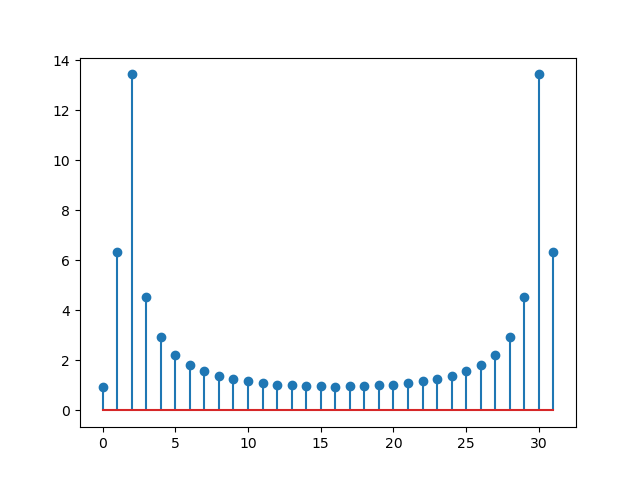

In [3]:
N = 32
n = np.arange(N)

xn = cos(pi/10*n)

Xm = np.fft.fft(xn)

plt.close(2); plt.figure(2)
plt.stem(np.abs(Xm))

# Spektral lekkasje

* DFT av $N$ sampler fra et signal $x[n]$ vil i realiteten finne en måte å dekomponere akkurat disse $N$ samplene til $x[n]$ i $N$ frekvenskomponenter med digital frekens $\hat{\omega}_k = \Delta \hat{\omega}\cdot k = 2\pi \frac{k}{N}$.
* Dersom signalet $x[n]$ inneholder frekvenskomponenter med frekvens $\hat{\omega} \notin \hat{\omega}_k$, vil vi få spektral lekkasje.
    * Vi vil få utslag i en rekke frevkenser $\hat{\omega}_k$ som kompenserer for frekvenskomponenten som ikke er "på lista".
    * Størst utslag vil finne sted der $\hat{\omega}_k$ er nærmest $\hat{\omega}$.

* *Årsaken til at dette skjer blir tydelig når vi forsøker å rekonstruere den analoge bølgeformen til $x(t)$ med utgangspunkt i DFT-sekvensen $X[n]$.*

* Rekonstruksjon av analogt signal kan utføres ved å anse $X[k]$ som fourierrekke-koeffisienter $a_k=A_k\cdot e^{j\phi_k}$ for $0\leq k \leq \frac{N}{2}$, og generere et analogt signal med følgende formel:
$$x(t) = X[0] + 2\cdot \sum_{k=1}^{N/2} |X[k]| \cdot \cos\left(2\pi \frac{k\cdot f_s}{N}\cdot t + \angle X[k]\right)$$

## Signalrekonstruksjon illustrert 
* Figuren viser rekonstruert signal med utangspunkt i 32-punkts DFT
* *Bruker for enkelhets skyld $f_s = N = 32$ for eksempelet*

<img src="Figurer/07_Frekvensanalyse/Fig1_SpecLeakTimeDomain.png" style="width: 80%; margin-left: 100px" />

# Refleksjoner
* En $N$-punkts DFT av et signal $x[n]$ gir frekvensinnholdet til et "hypotetisk" signal som ***er*** periodisk over vinduslengden på $N$ sampler uavhengig av om det relle signalet $x[n]$ er periodisk over dette sampleintervallet.
* Hvorvidt spektral lekkasje oppstår avhengig av hvor stor foskjell det er mellom det "hypotetiske" signalet og det reelle singalet.

## Demo spektral lekkasje

Output()

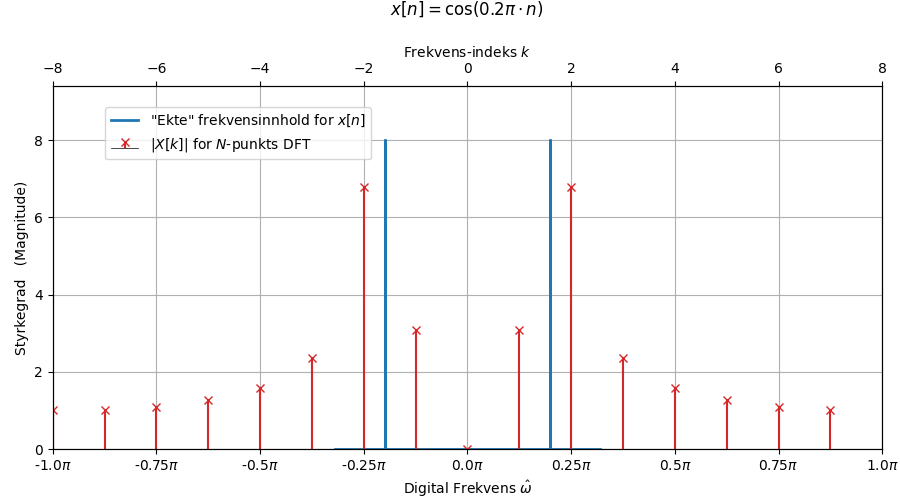

In [2]:
SpectralLeakageDemo(figsize=(9,5)); # Figurstørrelsen kan endres for å tilpasse dokumentvisning.

## Regneeksempel 1:
* Et signal $x(t) = \cos(2\pi\cdot 570 \cdot t)$ samples med samplingsfrekvens $f_s = 4000Hz$. Et utsnitt med lengde $N=256$ sampler brukes deretter til å regne ut en DFT-sekvens $X[k]$ som vil være utgangspuntet til å utføre frekvensanalyse av signalet. For hvilken verdi $k$ finner vi elementet $X[k]$ med størst absoluttverdi? Hvilken frekvens tilsvarer dette?

# Vindusfunksjoner

* En ***vindusfunksjon*** er et nyttig verktøy for å redusere konsekvensene av spektral lekkasje.
    * Med en spesiell manipulasjon av signalutklippet fra $x[n]$ *før* utregning av DFT, kan vi endre frekvensinnholdet i ønsket retning.
    * Vindusfunksjonen vil påføre en vekting av hver sample $x[n]$ avhengig av sampleverdien $n$.
    * Samplene nære "kantene" på vinduet vil krympes, slik at differansen mellom $x[0]$ og $x[N-1]$ blir minimal. 
    * Dette fjerner kunstige "sprang" i det hypotetiske periodiske signalet vi *faktisk* finner frekvensinnholdet til.

# Eksempel: hann vindu

### $$ w[n] = \begin{cases}
0.5 - 0.5 \cos \left( 2\pi \frac{n}{N} \right) \ \ ,& 0 \leq n <N \\
0, & \text{Otherwise}
\end{cases}$$

<img src="Figurer/07_Frekvensanalyse/Fig2_HannWindow.png" style="width: 80%; margin-left: 100px" />

## Kodeeksempel 2:
* Generer $N=32$ sampler av det digitale signalet $x[n] = \cos\left(\frac{\pi}{10} \cdot n\right)$, og regn ut signalvinduets DFT-sekvens $X[m]$.
* Utfør vekting av signalet $x[n]$ med en *hann* vindusfunksjon, regn ut DFT, og vis amplitudespekteret $\left| X[m]\right|$ som et stolpediagram.

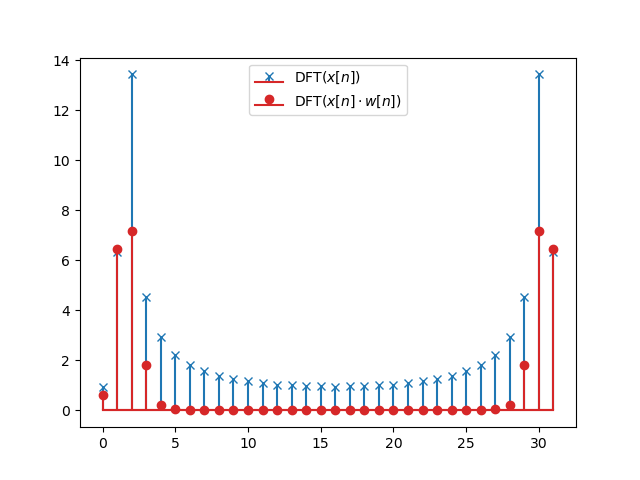

In [5]:
import scipy.signal as sig
N = 32
n = np.arange(N)
xn = cos(pi/10*n)

wn = 0.5 - 0.5*cos(2*pi*n/N)
#wn = sig.hann(N)
xn_win = xn*wn

Xm = np.fft.fft(xn)

Xm_win = np.fft.fft(xn_win)


plt.close(3); plt.figure(3)
plt.stem(n, np.abs(Xm), markerfmt='x', label = r"DFT$(x[n])$")

plt.stem(n, np.abs(Xm_win), markerfmt='C3o', linefmt='C3', label = r"DFT$(x[n]\cdot w[n])$")
plt.legend()

## Observasjoner om vindusfunksjoner

* Begrenser spektral lekkasje i større grad til de nærmeste "nabo-verdiene" i langs frekvensaksen. 
* Medfører en reduksjon i styrkegrad da mye av signalet reduseres i ampitude.
    * Ikke et problem, da alle frekvenskomponenter i signalet vil påvirkes likt.
* Gir ikke bedre presisjon for identifisering av riktig frekvens for et signalelement.


<img src="Figurer/07_Frekvensanalyse/Fig3-1_Leakage.png" style="width: 80%; margin-left: 100px" />

* Kan vi øke frekvensoppløsningen uten å øke vinduslengden?

# Zero padding
* Metode for å få flere frekvenssampler uten å øke vinduslengden.
* "padder" signalet med nullsampler bak signalutklippet.
    * Dersom man bruker vindusfunksjon, gjøres dette *før* zero padding.
* Vi regner så ut DFT av det nye utvidede signalet.

<img src="Figurer/07_Frekvensanalyse/Fig3_ZeroPadding.jpg" style="width: 80%; margin-left: 100px" />

## Kodeeksempel 3:
1. Bruk zero padding til å øke doble antallet frekvenssampler DFT-sekvensen i forrige eksempel vi produsere.
2. Gjør justeringer slik at figuren viser tosidig frekvensspekter der x-aksen viser *Normalisert Vinkelfrekvens* $\hat{\omega}$.

Text(0.5, 0, 'Normalisert vinkelfrekvens ($\\times 2\\pi$)')

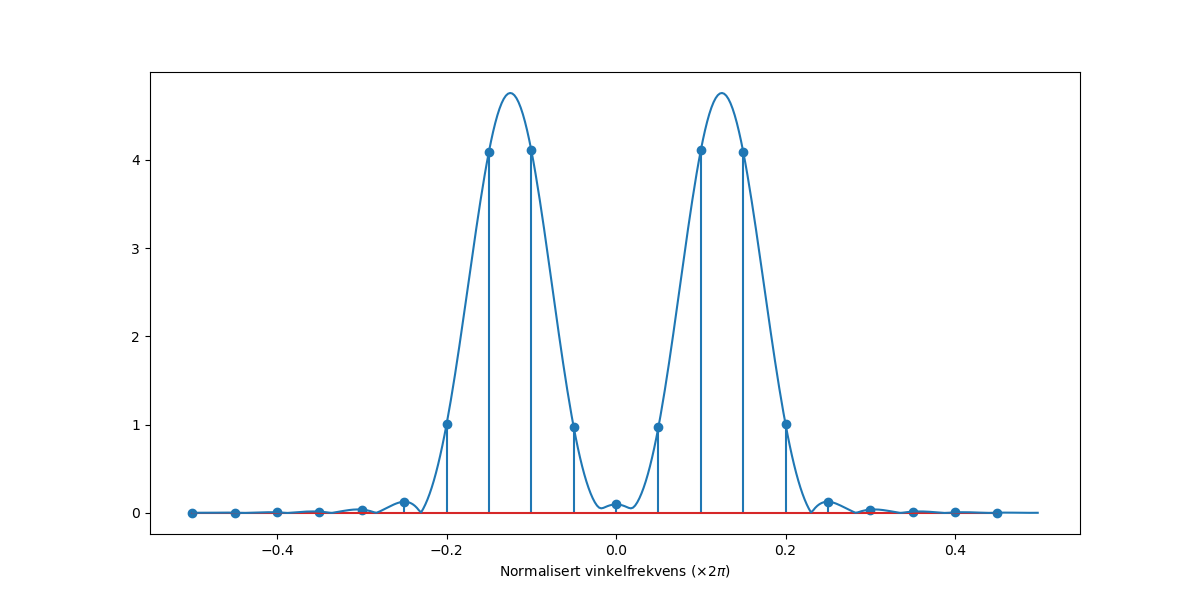

In [17]:
import scipy.signal as sig
N = 20
n = np.arange(N)
xn = cos(pi*0.25*n)

#wn = 0.5 - 0.5*cos(2*pi*n/N)
wn = sig.hann(N)
xn_win = xn*wn

xn_padded = np.concatenate((xn_win, np.zeros(19*N)))
                           
Xm_win = np.fft.fft(xn_win)
Xm_win = np.fft.fftshift(Xm_win)
f = np.fft.fftfreq(len(Xm_win))
f = np.fft.fftshift(f)

Xm_pad = np.fft.fft(xn_padded)
Xm_pad = np.fft.fftshift(Xm_pad)
f2 = np.fft.fftfreq(len(Xm_pad))
f2 = np.fft.fftshift(f2)

plt.close(2); plt.figure(2, figsize=(12,6))
#plt.stem(xn_padded)
                                              
plt.stem(f, np.abs(Xm_win))
plt.plot(f2, np.abs(Xm_pad))
plt.xlabel(r'Normalisert vinkelfrekvens ($\times 2\pi$)'),

## Quiz-spørsmål:
* Et signal er samplet med samplingsfrekvens $f_s = 4000Hz$, og vi har plukket ut $N=1000$ sampler for å utføre frekvensanalyse. Hvor mange null-sampler må vi legge til for at DFT-sekvensen skal ha oppløsningsbåndbredde $\Delta f = 1Hz$?

# Vindusfunksjoner og zero padding i praksis
Funksjoner som [`magnitude_spectrum`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html) i matplotlib biblioteket kan også ta imot parametre for både vindusfunksjoner og zero padding.

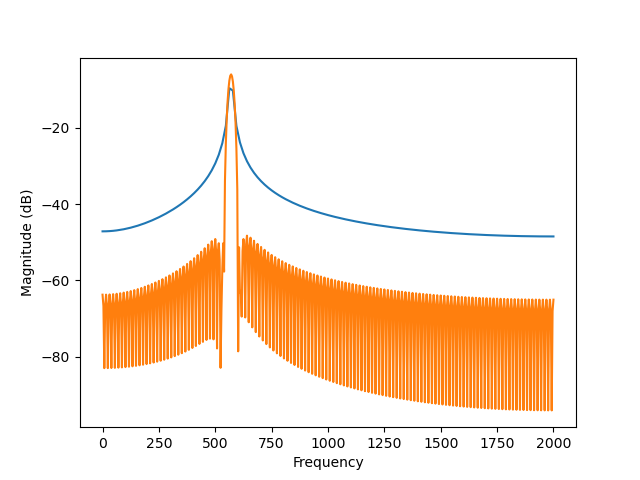

In [22]:
f = 570
f_s = 4000

N = 256
n = np.arange(N)

xn = cos(2*pi*f/f_s*n) 

plt.figure()
plt.magnitude_spectrum(xn, 
                       Fs=f_s, 
                       window = np.ones(N),
                       scale = 'dB'
                      );

plt.magnitude_spectrum(xn, 
                       Fs=f_s, 
                       window = np.hamming(N),
                       pad_to = 1024,
                       scale = 'dB'
                      );

# Spørsmål?